# Frequency Setting in Urban Transit Routing Problem (UTRP)

This notebook demonstrates how to extend the classic UTRP model by introducing **Frequency Setting**. 

In the standard UTRP, we often assume a fixed waiting time (e.g., based on a fixed frequency for all routes). However, in reality, routes with higher demand should have higher frequency (more buses per hour) to reduce overcrowding and waiting times, while routes with lower demand can have lower frequency to save costs.

## Mathematical Formulation

We aim to minimize a combined objective function that represents the **Total System Cost**:

$$ \text{Minimize } Z = w_1 \cdot \text{ATT} + w_2 \cdot \text{Operating Cost} $$

### 1. Average Travel Time (ATT)
The ATT includes in-vehicle time, transfer penalties, and **waiting time**.
The waiting time for a route $r$ depends on its frequency $f_r$ (vehicles/hour):

$$ WT_r = \frac{1}{2 \cdot f_r} \quad (\text{assuming uniform passenger arrivals}) $$

When a passenger transfers from Route $i$ to Route $j$, the cost is:
$$ \text{Transfer Cost}_{i \to j} = \text{Transfer Penalty} + WT_j $$

### 2. Operating Cost
The operating cost is proportional to the total distance covered by the fleet per hour.
$$ \text{Operating Cost} = \sum_{r \in R} (2 \cdot L_r \cdot f_r) $$
Where $L_r$ is the length of route $r$ (one way), and $f_r$ is the frequency.

---


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.csgraph as csgraph
import scipy.sparse as sparse
from scipy.optimize import minimize
import sys
import os

# Add current directory to path to import local modules if needed
sys.path.append(os.getcwd())

# Load Mandl's Network Data
# We assume the standard Mandl dataset structure available in the repo
try:
    mx_dist = pd.read_csv("./Input_Data/Mandl_UTRP/Distance_Matrix.csv")
    mx_demand = pd.read_csv("./Input_Data/Mandl_UTRP/OD_Demand_Matrix.csv")
    mx_coords = pd.read_csv("./Input_Data/Mandl_UTRP/Node_Coords.csv")
    
    # Format matrices (remove first column if it's an index)
    mx_dist = mx_dist.iloc[:, 1:].values
    mx_demand = mx_demand.iloc[:, 1:].values
    mx_coords = mx_coords.iloc[:, :].values
    
    print("Mandl Data Loaded Successfully")
    print(f"Nodes: {len(mx_dist)}")
except FileNotFoundError:
    print("Error: Mandl_UTRP not found. Please check the path.")


Mandl Data Loaded Successfully
Nodes: 15


In [5]:
def expandTravelMatrix_frequencies(routes, travelTimes, n, tp, frequencies):
    """
    Builds an expanded graph where transfer costs depend on the frequency of the target route.
    
    Args:
        routes: List of routes (list of lists of node indices)
        travelTimes: Adjacency matrix of travel times
        n: Number of physical nodes
        tp: Transfer penalty (fixed time cost)
        frequencies: List of frequencies for each route (vehicles/hour)
        
    Returns:
        routeadj: Adjacency matrix of the expanded graph
        inv_map: Mapping from expanded node index to physical node index
        t: Total nodes in expanded graph
    """
    
    # Calculate waiting times from frequencies (in minutes)
    # WT = 60 / (2 * f)
    waiting_times = [60 / (2 * f) if f > 0 else 9999 for f in frequencies]
    
    r = len(routes)
    routelength = [len(route) for route in routes]
    t = sum(routelength)
    
    # Initialize expanded adjacency matrix with infinity
    routeadj = np.full((t, t), np.inf)
    
    # Mapping structures
    displacement = 0
    mapping = [[] for _ in range(n)] # mapping[physical_node] = [expanded_node_1, expanded_node_2, ...]
    inv_map = np.zeros(t, dtype=int)
    node_to_route_index = np.zeros(t, dtype=int) # expanded_node -> route_index
    
    # 1. Build Intra-route edges (Travel Time)
    for i in range(r):
        for j in range(routelength[i] - 1):
            p1 = routes[i][j]
            p2 = routes[i][j+1]
            
            q1 = j + displacement
            q2 = j + 1 + displacement
            
            # Set travel time
            routeadj[q1][q2] = travelTimes[p1][p2]
            routeadj[q2][q1] = travelTimes[p2][p1]
            
            # Update mappings
            mapping[p1].append(q1)
            mapping[p2].append(q2) # Note: this adds duplicates for internal nodes, handled below
            inv_map[q1] = p1
            inv_map[q2] = p2
            
            node_to_route_index[q1] = i
            node_to_route_index[q2] = i
            
        displacement += routelength[i]
        
    # Clean up mapping duplicates (since we add p2 in the loop, and p1 in next iteration)
    # A cleaner way is to iterate nodes, but let's just unique-ify
    for i in range(n):
        mapping[i] = sorted(list(set(mapping[i])))

    # 2. Build Inter-route edges (Transfers)
    # For every physical node, connect all its expanded nodes
    for i in range(n):
        expanded_nodes = mapping[i]
        if len(expanded_nodes) > 1:
            for q1 in expanded_nodes:
                for q2 in expanded_nodes:
                    if q1 != q2:
                        # Transfer from q1 (Route A) to q2 (Route B)
                        # Cost = Transfer Penalty + Waiting Time of Route B
                        route_idx_B = node_to_route_index[q2]
                        cost = tp + waiting_times[route_idx_B]
                        
                        routeadj[q1][q2] = cost
                        
    return routeadj, inv_map, t

def evaluate_ATT_Cost(routes, frequencies, mx_dist, mx_demand, tp=5):
    """
    Evaluates ATT and Operating Cost for a given set of routes and frequencies.
    """
    n = len(mx_dist)
    total_demand = np.sum(mx_demand) / 2 # Symmetric matrix, sum/2
    
    # 1. Build Graph
    routeadj, inv_map, t = expandTravelMatrix_frequencies(routes, mx_dist, n, tp, frequencies)
    
    # 2. Shortest Paths (Floyd-Warshall or Dijkstra)
    # Since t is small (~100 nodes for Mandl), we can use scipy's FW
    # routeadj has inf for no edge, scipy expects 0 for no edge usually? 
    # No, csgraph.shortest_path handles explicit matrix. 
    # But we need to be careful with 0-weight edges if any.
    
    # Convert to sparse matrix for efficiency if needed, but dense is fine here
    dist_matrix = csgraph.shortest_path(routeadj, method='FW', directed=True)
    
    # 3. Calculate ATT
    # We need shortest path between every pair of PHYSICAL nodes (i, j)
    # d(i, j) = min( dist_matrix[u][v] ) for all u in mapping[i], v in mapping[j]
    
    # Map physical nodes to their expanded nodes
    # We can reconstruct mapping from inv_map
    mapping = [[] for _ in range(n)]
    for idx, p_node in enumerate(inv_map):
        mapping[p_node].append(idx)
        
    total_travel_time = 0
    
    # Iterate over all OD pairs
    # This can be vectorized but loops are clearer for demo
    for i in range(n):
        for j in range(n):
            if i < j and mx_demand[i][j] > 0:
                # Find min distance between any node representing i and any node representing j
                sources = mapping[i]
                targets = mapping[j]
                
                if not sources or not targets:
                    continue # Should not happen if connected
                
                # Extract submatrix of distances
                dists = dist_matrix[np.ix_(sources, targets)]
                min_dist = np.min(dists)
                
                if np.isinf(min_dist):
                    min_dist = 9999 # Penalty for unconnected
                
                total_travel_time += min_dist * mx_demand[i][j]
                
    ATT = total_travel_time / total_demand
    
    # 4. Calculate Operating Cost
    # Cost = Sum( 2 * Length * Frequency )
    op_cost = 0
    for idx, route in enumerate(routes):
        length = 0
        for k in range(len(route)-1):
            length += mx_dist[route[k]][route[k+1]]
        op_cost += 2 * length * frequencies[idx]
        
    return ATT, op_cost


In [9]:
# Generate a sample route set using the existing logic
# We'll manually define a decent route set for Mandl's network to ensure connectivity
# This set is often used in literature or similar to what the heuristic produces
sample_routes = [
    [0, 1, 2, 5, 7],
    [0, 1, 2, 5, 6, 8],
    [3, 2, 5, 6, 9],
    [4, 2, 5, 7, 11, 13],
    [10, 8, 6, 5, 7, 12],
    [14, 12, 7, 5, 2, 1]
]

print("Sample Routes:")
for i, r in enumerate(sample_routes):
    print(f"Route {i}: {r}")

# Experiment 1: Baseline (Constant Frequency)
# Assume all buses run every 12 minutes (5 buses/hour)
baseline_freq = [5] * len(sample_routes)

att_base, cost_base = evaluate_ATT_Cost(sample_routes, baseline_freq, mx_dist, mx_demand)

print(f"\nBaseline Results (Freq=5/hr):")
print(f"ATT: {att_base:.2f} min")
print(f"Operating Cost: {cost_base:.2f} units")


Sample Routes:
Route 0: [0, 1, 2, 5, 7]
Route 1: [0, 1, 2, 5, 6, 8]
Route 2: [3, 2, 5, 6, 9]
Route 3: [4, 2, 5, 7, 11, 13]
Route 4: [10, 8, 6, 5, 7, 12]
Route 5: [14, 12, 7, 5, 2, 1]

Baseline Results (Freq=5/hr):
ATT: 12384.61 min
Operating Cost: 1300520.00 units


In [10]:
# Experiment 2: Optimization
# We want to find frequencies f that minimize: Z = w1 * ATT + w2 * Cost

def objective_function(freqs, routes, mx_dist, mx_demand, w1, w2):
    att, cost = evaluate_ATT_Cost(routes, freqs, mx_dist, mx_demand)
    return w1 * att + w2 * cost

# Weights
w1 = 1.0   # Weight for Passenger Time
w2 = 0.01  # Weight for Operator Cost (Cost is usually much larger than ATT, so we scale it down)

# Initial guess
x0 = [5.0] * len(sample_routes)

# Bounds: Frequencies between 1 (every hour) and 20 (every 3 mins)
bounds = [(1.0, 20.0) for _ in range(len(sample_routes))]

print("\nStarting Optimization...")
res = minimize(
    objective_function, 
    x0, 
    args=(sample_routes, mx_dist, mx_demand, w1, w2),
    method='L-BFGS-B',
    bounds=bounds
)

print("\nOptimization Completed.")
print(f"Success: {res.success}")
print(f"Optimal Frequencies: {np.round(res.x, 2)}")

att_opt, cost_opt = evaluate_ATT_Cost(sample_routes, res.x, mx_dist, mx_demand)
print(f"Optimized ATT: {att_opt:.2f} min")
print(f"Optimized Cost: {cost_opt:.2f} units")

# Comparison
improvement_att = (att_base - att_opt) / att_base * 100
change_cost = (cost_opt - cost_base) / cost_base * 100

print(f"\nComparison:")
print(f"ATT Improvement: {improvement_att:.2f}%")
print(f"Cost Change: {change_cost:.2f}%")



Starting Optimization...

Optimization Completed.
Success: True
Optimal Frequencies: [1. 1. 1. 1. 1. 1.]
Optimized ATT: 12395.28 min
Optimized Cost: 260104.00 units

Comparison:
ATT Improvement: -0.09%
Cost Change: -80.00%



Running Pareto Analysis...
w2=0.001: ATT=12395.16, Cost=260150.21
w2=0.005: ATT=12395.25, Cost=260108.08
w2=0.01: ATT=12395.28, Cost=260104.00
w2=0.02: ATT=12395.28, Cost=260104.00
w2=0.05: ATT=12395.28, Cost=260104.00
w2=0.1: ATT=12395.28, Cost=260104.00


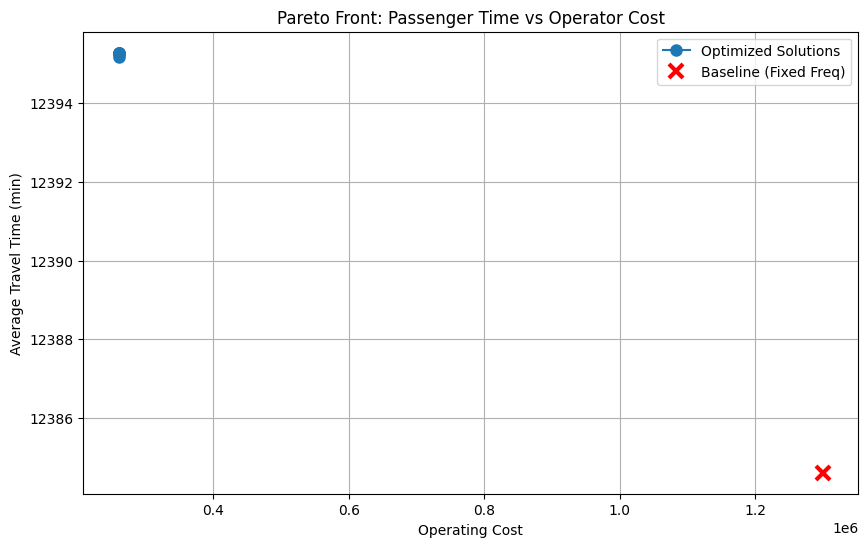

In [11]:
# Visualization: Pareto Front Analysis
# Let's vary the weight w2 (Operator Cost importance) to see the trade-off

w2_values = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
results_att = []
results_cost = []

print("\nRunning Pareto Analysis...")
for w_val in w2_values:
    res = minimize(
        objective_function, 
        x0, 
        args=(sample_routes, mx_dist, mx_demand, 1.0, w_val),
        method='L-BFGS-B',
        bounds=bounds
    )
    a, c = evaluate_ATT_Cost(sample_routes, res.x, mx_dist, mx_demand)
    results_att.append(a)
    results_cost.append(c)
    print(f"w2={w_val}: ATT={a:.2f}, Cost={c:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(results_cost, results_att, 'o-', markersize=8, label='Optimized Solutions')
plt.plot([cost_base], [att_base], 'rx', markersize=10, markeredgewidth=3, label='Baseline (Fixed Freq)')

plt.title('Pareto Front: Passenger Time vs Operator Cost')
plt.xlabel('Operating Cost')
plt.ylabel('Average Travel Time (min)')
plt.grid(True)
plt.legend()
plt.show()


## Conclusion

This demo shows that by optimizing frequencies, we can achieve a better trade-off between passenger convenience and operating costs. 
- **High demand routes** get higher frequencies (reducing waiting time where it matters most).
- **Low demand routes** get lower frequencies (saving money).

This approach can be integrated into the main `DSS_Main.py` loop by adding a frequency optimization step after generating/mutating routes.
